# KMeans Extended for Abstracted Distance Metrics

I have occasionally encountered problems where I want to use KMeans to cluster something by a metric other than euclidean. A common example is text data, which may have been one-hot encoded by n-grams, which is more appropriately analyzed with the cosine distance. Here I write such a class and try it out on text data.

In [64]:
from sklearn.datasets import fetch_20newsgroups
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import cosine_distances,euclidean_distances
import numpy as np
import pandas as pd


The sample data I'll use is the newsgroups dataset. 

In [65]:

newsgroups = fetch_20newsgroups(subset='all', categories=None, remove=('headers', 'footers', 'quotes'))
print(f"Number of documents: {len(newsgroups.data)}")
print(f"Categories: {newsgroups.target_names}")

print("\nSample Document:")
print(newsgroups.data[0])

Number of documents: 18846
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Sample Document:


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the

I'll take stopwords from the spacy en_core_web_lg model. I prefer these stopwords to other sets that I've used.

In [66]:
nlp = spacy.load("en_core_web_lg")
stop_words = nlp.Defaults.stop_words


In [67]:
len(newsgroups['target'])

18846

In [68]:
cleaned = ["".join([j for j in i if (j==' ')|(j.isalpha())|(j==".")]) for i in newsgroups['data']]

Here I'll begin to procedurally create the KMeans functionality, starting starting with vectorization of the text (which I've dropped special characters from above).

In [85]:

vectorizer = TfidfVectorizer(max_features=10000,stop_words=list(stop_words),ngram_range=(1,1))
tfidf_matrix = vectorizer.fit_transform(cleaned)

# Ignore the warning. It's fine.

d:\git-control\ml-research\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Here I'll specify k=8, and sample 8 points as the starting centroids. I'm not using any more intelligent init than this for now. I will however make sure all initial centroids have at least one datapoint in its cluster.

In [86]:
k=8

all_clusts_represented = False

while not all_clusts_represented:
    sampled_indices = np.random.choice(tfidf_matrix.shape[0],size=k,replace=False)

    centroids = tfidf_matrix[sampled_indices]

    dists = cosine_distances(
        tfidf_matrix,
        centroids
    )
    argmins=dists.argmin(axis=1)

    all_clusts_represented = set(argmins)==set(range(8))

Here is the iterative process to optimize the clusters.

In [87]:
for e in range(121):
    dists = cosine_distances(
        tfidf_matrix,
        centroids
    )
    argmins=dists.argmin(axis=1)

    new_centroids = []
    for c in range(k):
        row = tfidf_matrix[argmins==c].mean(axis=0)
        new_centroids.append(row)
    
    new_centroids = np.concat(new_centroids)

    print(e,(new_centroids-centroids).sum())

    if abs((new_centroids-centroids).sum())==0:
        centroids = np.asarray(new_centroids)
        break

    centroids = np.asarray(new_centroids)

dists = cosine_distances(tfidf_matrix,centroids)
argmins = dists.argmin(axis=1)
centroid_dist = dists[:,list(argmins)][:,0]



0 6.6642246184946545
1 -0.9913819640552359
2 -0.4442156172091642
3 -0.16575782308818476
4 0.0606105097915101
5 0.0013657194998474044
6 -0.12113849400018224
7 -0.23945273277416268
8 -0.21323870167407025
9 -0.08368806760449127
10 -0.03613889074857175
11 -0.0026929292243466907
12 -0.009323828087879037
13 0.0006994725868217529
14 -0.003661917317445025
15 0.00739380701603219
16 0.00806988861367905
17 0.003450672145090694
18 0.005340510451591148
19 -0.0008194191372394961
20 0.0037453289012704598
21 0.0012871399078039944
22 -0.0034439497432784353
23 -8.22765906012925e-05
24 -0.0002210052697133409
25 -0.00017533247809600787
26 0.00010063281874329763
27 -0.00037106739867599764
28 1.1568935235250133e-05
29 0.0


Having developed the procedure, here I'll wrap it in an SKLearn base class.

In [111]:
from sklearn.base import BaseEstimator,ClusterMixin

class KMeansExtended(BaseEstimator,ClusterMixin):

    def __init__(
        self,
        n_clusters=5,
        metric='cosine',
        epochs=100,
        verbose=False
    ):
        
        self.n_clusters=n_clusters
        self.epochs=epochs
        self.metric = metric
        self.verbose = verbose

        if metric=='cosine':
            self.metric_fn = cosine_distances
        else:
            self.metric_fn = euclidean_distances


    def fit(self,X,y=None):
        """Compute k-means clustering.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training instances to cluster.

        y : Ignored
            Not used, present here for API consistency by convention.

        Returns
        -------
        self : object
            Fitted estimator.
        """
                
        all_clusts_represented = False

        while not all_clusts_represented:
            sampled_indices = np.random.choice(X.shape[0],size=self.n_clusters,replace=False)

            self.cluster_centers_ = X[sampled_indices]
            dists = cosine_distances(
                X,
                self.cluster_centers_
            )
            argmins=dists.argmin(axis=1)

            all_clusts_represented = set(argmins)==set(range(self.n_clusters))

        for e in range(self.epochs):

            dists = self.metric_fn(
                X,
                self.cluster_centers_
            )
            argmins=dists.argmin(axis=1)

            new_centroids = []
            for c in range(self.n_clusters):
                row = tfidf_matrix[argmins==c].mean(axis=0)
                new_centroids.append(row)
            
            new_centroids = np.concat(new_centroids)
            if self.verbose:
                print(e,(new_centroids-self.cluster_centers_).sum())

            if abs((new_centroids-self.cluster_centers_).sum())==0:
                self.cluster_centers_ = np.asarray(new_centroids)
                break

            self.cluster_centers_ = np.asarray(new_centroids)
  
        dists = self.metric_fn(
            X,
            self.cluster_centers_
        )
        self.labels_ = dists.argmin(axis=1)

        return self

    def predict(self,X):
        """Predict the closest cluster each sample in X belongs to.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data to predict.

        Returns
        -------
        labels : ndarray of shape (n_samples,)
            Index of the cluster each sample belongs to.
        """

        dists = self.metric_fn(
            X,
            self.cluster_centers_
        )
        labels = dists.argmin(axis=1)

        return labels






In [112]:
kmeans = KMeansExtended(n_clusters=20,metric='cosine',epochs=100)


In [113]:
kmeans.fit(tfidf_matrix)

KMeansExtended(n_clusters=20)

In [114]:
kmeans.predict(tfidf_matrix)

array([15, 19,  9, ...,  2,  0, 16])

In [115]:
kmeans_df = pd.DataFrame(
    {
        'data':cleaned,
        'target':newsgroups['target'],
        'cluster':kmeans.predict(tfidf_matrix)
    }
)

In [116]:
kmeans_df

,data,target,cluster
0,I am sure some bashers of Pens fans are pretty...,10,15
1,My brother is in the market for a highperforma...,3,19
2,Finally you said what you dream about. Mediter...,17,9
3,ThinkIts the SCSI card doing the DMA transfers...,3,19
4,I have an old Jasmine drive which I cannot...,4,19
...,...,...,...
18841,DN From nyedacnsvax.uwec.edu David NyeDN A neu...,13,5
18842,Not in isolated ground recepticles usually an ...,12,2
18843,I just installed a DX CPU in a clone motherboa...,3,2
18844,Wouldnt this require a hypersphere. In space ...,1,0


In [117]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [125]:
pca = PCA(n_components=2)

In [126]:
Xpca = pca.fit_transform(tfidf_matrix)

In [127]:
kmeans_df[['PCA1','PCA2']]=Xpca

kmeans_df['NAMES'] = kmeans_df['target'].map({i:j for i,j in enumerate(newsgroups['target_names'])})

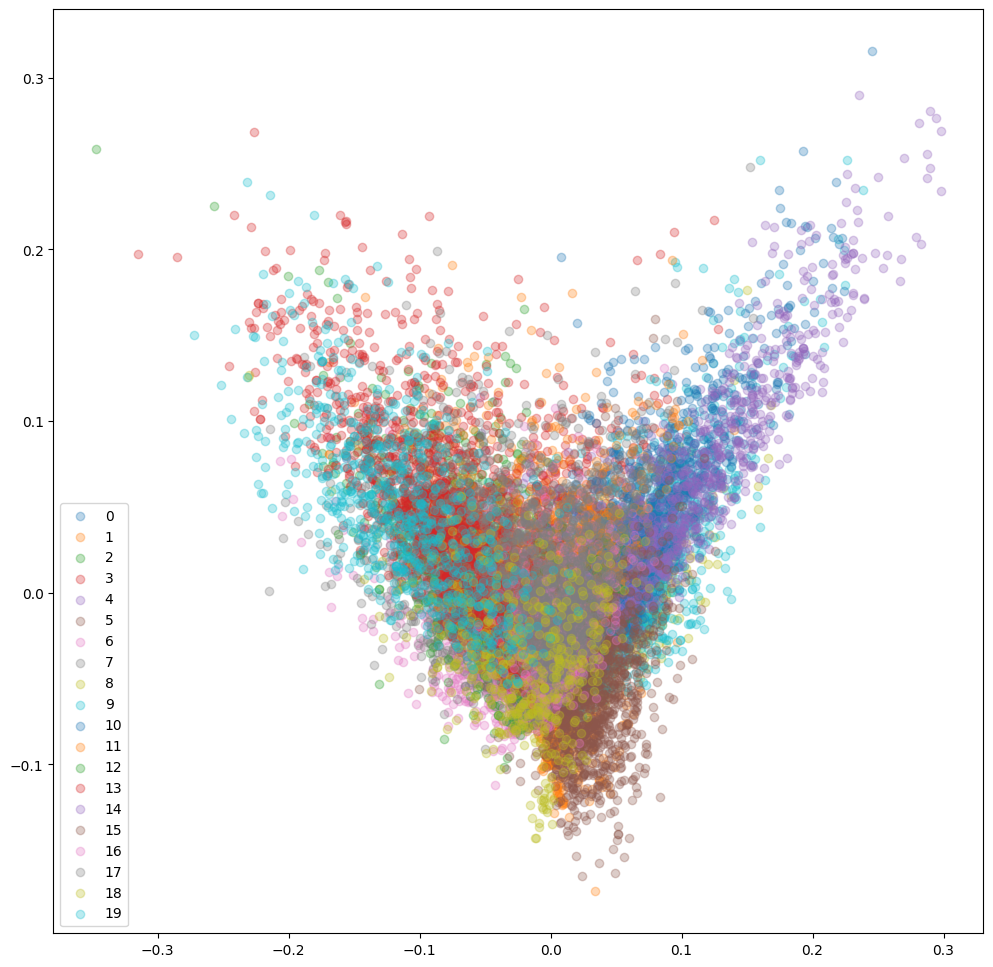

In [131]:
fig = plt.figure(figsize=(12,12))

for c in range(20):
    tmp = kmeans_df[kmeans_df['cluster']==c].copy()
    plt.scatter(tmp['PCA1'],tmp['PCA2'],label=c,alpha=.3)

plt.legend()
plt.show()

In [135]:
kmeans_df[kmeans_df['cluster']==0]['data'].to_list()[:20]

['ed.  All of us that argue about gyroscopes etc. throughly understandedthe technique of countersteering.meIncluding all the ones who think that they countersteer all the waymethrough a corneredWell... all the way through a decreasingradius corner anyway...Maybe they are riding around an everdecreasing circle of lies whicheventually leads to the truth....meThe official line here though I do have my doubts about it is that themefront brake is applied first followed by the rear brake the idea beingmethat you avoid locking up the rear after weight transfer takes place. Me too though unfortunately the Official Line is the one that youhave to adhere to if you want to get a full licence. The examinersguidelines are laid down by the government and the basic rider educationcourses have no choice but to follow them. It surprises me that none of therider groups here either MAG or the BMF make much noise about the fact thatthe riding test requires you to ride three feet from the kerb all the time

In [146]:
for i in range(20):
    print(i,"\n")
    print(kmeans_df[kmeans_df['cluster']==i].groupby(['NAMES'])['cluster'].count().sort_values(ascending=False))

0 

NAMES
sci.space                   549
rec.motorcycles             387
rec.autos                    77
sci.electronics              69
rec.sport.baseball           59
comp.os.ms-windows.misc      48
comp.graphics                47
comp.sys.mac.hardware        47
sci.med                      43
sci.crypt                    39
talk.politics.guns           34
alt.atheism                  33
rec.sport.hockey             32
talk.religion.misc           32
talk.politics.misc           32
talk.politics.mideast        31
misc.forsale                 29
soc.religion.christian       27
comp.windows.x               25
comp.sys.ibm.pc.hardware     22
Name: cluster, dtype: int64
1 

NAMES
rec.sport.hockey           281
rec.sport.baseball          50
misc.forsale                25
rec.motorcycles             12
alt.atheism                 11
rec.autos                    8
talk.religion.misc           8
talk.politics.guns           8
sci.electronics              8
sci.space                    7
ta